# Clique Analysis
Conducting a clique analysis of a network graph involves identifying and analyzing the cliques within the graph. A clique is a subset of nodes in a graph where every node is directly connected to every other node within the subset. 

In [3]:
import pandas as pd
import numpy as np
import networkx as nx 

import matplotlib.pyplot as plt
from ast import literal_eval

from os.path import join
import os

# from token_projection.token_projection import *
# from utilities.metrics_and_tests import * 
# from utilities.utils import * 

from dotenv import load_dotenv
load_dotenv()  

path = os.environ['DATA_DIRECTORY']
covalent_key = os.environ['COVALENTHQ_API_KEY']
df_snapshots = pd.read_csv('./data/snapshot_selection.csv')
df_tokens = pd.read_csv("./data/final_token_selection.csv")
# df_tokens = pd.read_csv('../assets/df_final_token_selection_20230813.csv')

# remove burner addresses 
known_burner_addresses = ['0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000001',
                        '0x0000000000000000000000000000000000000002',
                        '0x0000000000000000000000000000000000000003',
                        '0x0000000000000000000000000000000000000004',
                        '0x0000000000000000000000000000000000000005',
                        '0x0000000000000000000000000000000000000006',
                        '0x0000000000000000000000000000000000000007',
                        '0x000000000000000000000000000000000000dead']

### NOTE: YOU NEED TO RE-RUN TOKEN VALIDATION --> REMOVAL OF BITDAO CAUSED THIS.
### ALSO DOUBLE CHECK THAT BITDAO IS THE PROBLEM AND NOT AURA !!! 


In [4]:
from src.analysis.clique_analysis import * 

## Create dataframes for each metrics

In [8]:
import pickle

# Specify the path to the file containing the saved cliques data
cliques_data_path = join(path, 'data/cliques_data.pkl')

# Load the cliques dictionary from the file
with open(cliques_data_path, 'rb') as handle:
    cliques = pickle.load(handle)



In [9]:
# Define the list of metric names
metric_names = list(cliques['lower_bound']['sample']['2021-02-15']["""['YFI', 'AAVE']"""].keys())

# Initialize an empty dictionary to store DataFrames for each metric
# metric_dataframes = {'sample': {},'control': {}}

# metric_dataframes = {
#             'upper_bound': {'sample': {},'control': {}}, 
#             'lower_bound': {'sample': {},'control': {}}       
#             }

metric_dataframes = {
            'upper_bound': {'sample': {},'control': {},'pvalues': {}}, 
            'lower_bound': {'sample': {},'control': {},'pvalues': {}}       
            }


# Define a function to create a DataFrame for a given metric
def create_metric_dataframe(metric_name, key1, key2):
    data = []

    # Iterate through cliques and snapshots to collect data for the metric
    for date, snapshot_data in cliques[key1][key2].items():
        for clique_name, metrics in snapshot_data.items():
            
            try:
                data.append({
                'Date': date,
                'Clique Name': clique_name,
                metric_name: metrics[metric_name]
            })
            
            except:
                data.append({
                'Date': date,
                'Clique Name': clique_name,
                metric_name: np.nan
            })
            
            
            

    # Create a DataFrame for the metric
    df_metric = pd.DataFrame(data)

    # Pivot the DataFrame to have snapshots as columns and clique names as rows
    df_metric = df_metric.pivot(index='Clique Name', columns='Date', values=metric_name)

    # Store the DataFrame in the dictionary with a key representing the metric
    metric_dataframes[key1][key2][metric_name] = df_metric

# Call the function for each metric in the list

for method in ['upper_bound', 'lower_bound']:
    
    for group in ['sample', 'control', 'pvalues']:
        
        for metric_name in metric_names:
            
            create_metric_dataframe(metric_name, method, group)



## Figure Generation

In [10]:
FONT_SIZE_LABEL = 18
FONT_SIZE_TICK = 16
FONT_SIZE_TITLE = 24
LINE_SPACING=1.5
FONT_SIZE_VALUE = 12
FIG_SIZE = (18, 15)
COLORS = ['white', 'black']
COLORMAP = 'CMRmap'

### Fig: Size of Clique 

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_clique_size_over_time(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    
    # Define df 
    df = metric_dataframes[method][group]['size_clique']
    
    # common index
    df_index = metric_dataframes['upper_bound']['sample']['size_clique']

    # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 1).idxmax()

    # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()

    # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df_presence 
    df = df.reindex(cliques_order)

    # Create a mask for cells where 'clique_size' is greater than 1
    mask = df.values >= 1

    # Create a custom colormap with gray for values > 1 and white for values <= 1
    cmap = mcolors.ListedColormap(COLORS)

    # Create the binary chart with custom coloring
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    im = ax.imshow(mask, cmap=cmap, aspect='auto', interpolation='none')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns, rotation='vertical')
    ax.set_yticklabels(df.index, fontsize=FONT_SIZE_TICK, va='center', linespacing=LINE_SPACING)

    # Annotate the chart with 'clique_size' values, skipping 'NaN' values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            if not np.isnan(value):
                text = ax.text(j, i, (str(round(value))), ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=FONT_SIZE_LABEL)
    plt.ylabel('Cliques', fontsize=FONT_SIZE_LABEL)
    plt.title(f'[{method.upper()}]: Clique Size Over Time', fontsize=FONT_SIZE_TITLE)

    # Adjust spacing for vertical axis labels
    plt.tight_layout()
    
    # Save the plot to the specified output path
    if save == True:
        
        plt.savefig(join(output_path, f'clique_size_{method}_{group}.png'))
        
    if show != True:
        
        plt.close(fig)
    
    else: 
        
        plt.show() 
    

    
plot_clique_size_over_time(metric_dataframes, group='sample', save=False, show=False)

In [12]:
# Define df 
df_upper = metric_dataframes['upper_bound']['sample']['size_clique']
df_lower = metric_dataframes['lower_bound']['sample']['size_clique']

# common index
df_index = metric_dataframes['upper_bound']['sample']['size_clique']

# Find the index of the first occurrence (value > 1) in each column (snapshot)
first_occurrence_indices = (df_index.T > 1).idxmax()

# Determine the minimum index (earliest occurrence) for each clique across all snapshots
min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()

# Sort the cliques based on their minimum indices to get the desired order
cliques_order = min_indices.sort_values().index.tolist()

# Reindex clique size to df_presence 
df_upper = df_upper.reindex(cliques_order)
df_lower = df_lower.reindex(cliques_order)

NameError: name 'patches' is not defined

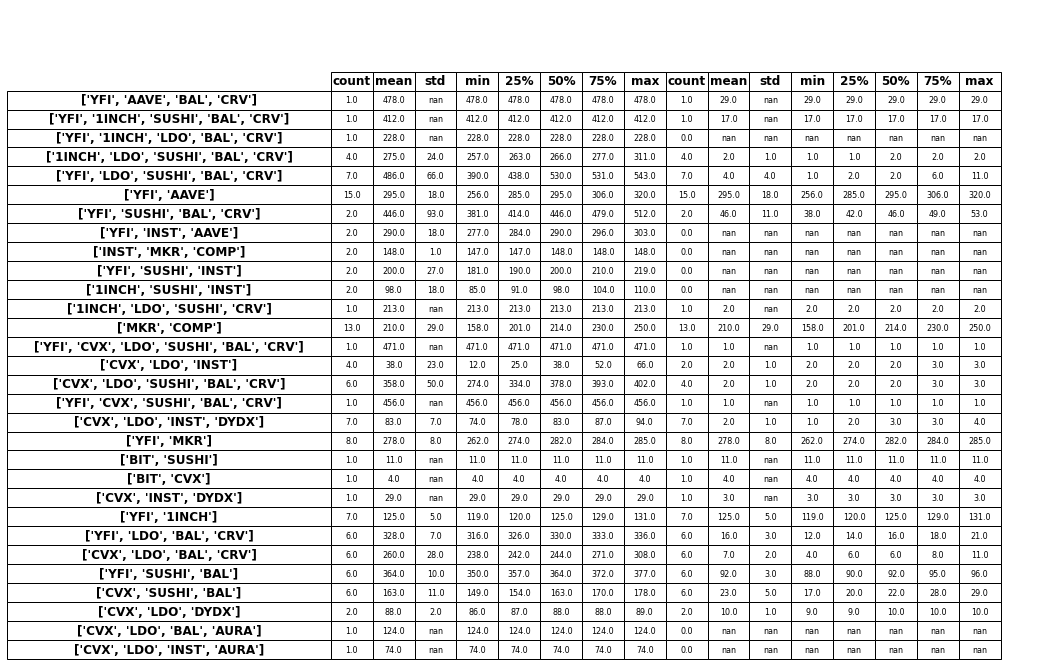

In [13]:
d1 = df_upper.T.describe().T.round(0)
d2 = df_lower.T.describe().T.round(0)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Remove axis
ax.axis('off')

# Adjusted coordinates for tables to be closer
bbox1 = [0.15, 0, 0.4, 0.9]
bbox2 = [0.55, 0, 0.4, 0.9]

# Place the "Upper-bound" table 
table1 = ax.table(cellText=d1.values, colLabels=d1.columns, rowLabels=d1.index, 
                  bbox=bbox1, cellLoc='center', rowLoc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(8)
table1.scale(1,2)

# Bold index rows for table1
for (i, j), cell in table1.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold', fontsize=12)
    if j == -1:  # Index column
        cell.set_text_props(weight='bold', fontsize=12)

# Place the "Lower-bound" table
table2 = ax.table(cellText=d2.values, colLabels=d2.columns, 
                  bbox=bbox2, cellLoc='center', rowLoc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(8)
table2.scale(1,2)

# Bold index rows for table1
for (i, j), cell in table2.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold', fontsize=12)
        
        
# Add bold bounding boxes around tables
bold_width = 1.2 
rect1 = patches.Rectangle((bbox1[0], bbox1[1]), bbox1[2], bbox1[3]+0.03, linewidth=bold_width, edgecolor='black', facecolor='none')
rect2 = patches.Rectangle((bbox2[0], bbox2[1]), bbox2[2], bbox2[3]+0.03, linewidth=bold_width, edgecolor='black', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

# Add centered titles above each box
ax.text(0.35, 0.92, 'Upper-bound', transform=ax.transAxes, va='top', ha='center', fontsize=12, fontweight='bold')
ax.text(0.75, 0.92, 'Lower-bound', transform=ax.transAxes, va='top', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout(pad=0)
# plt.subplots_adjust(left=0, right=0, top=0, bottom=0)
plt.savefig(join("output/cliques/", f'overview_clique_size.png'))

plt.show()


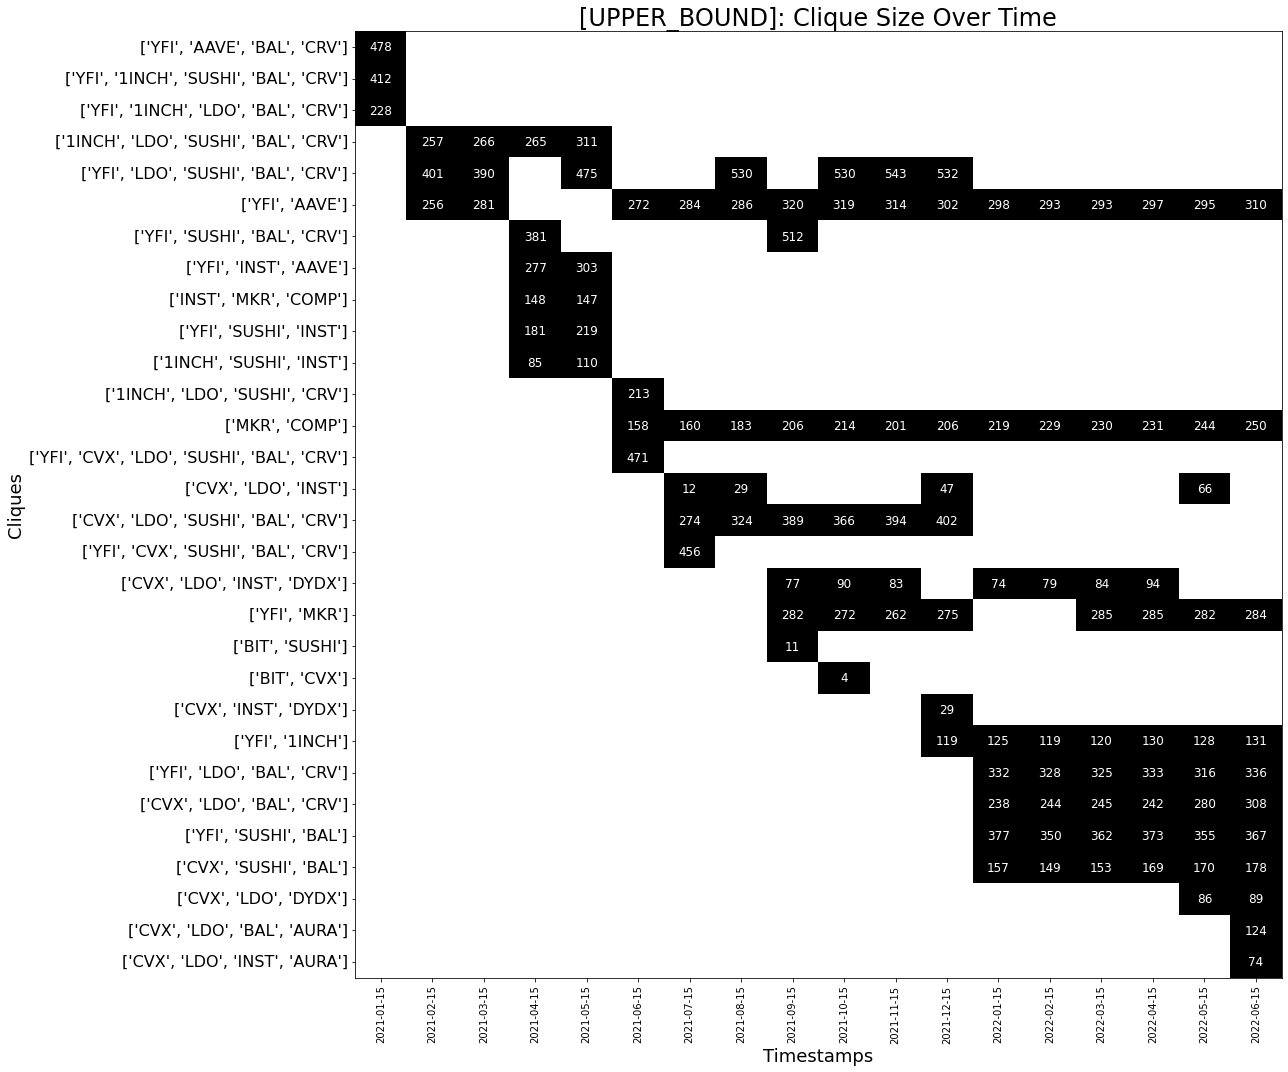

In [14]:
## show upper_bound
plot_clique_size_over_time(metric_dataframes, method='upper_bound', group='sample', save=True, show=True)

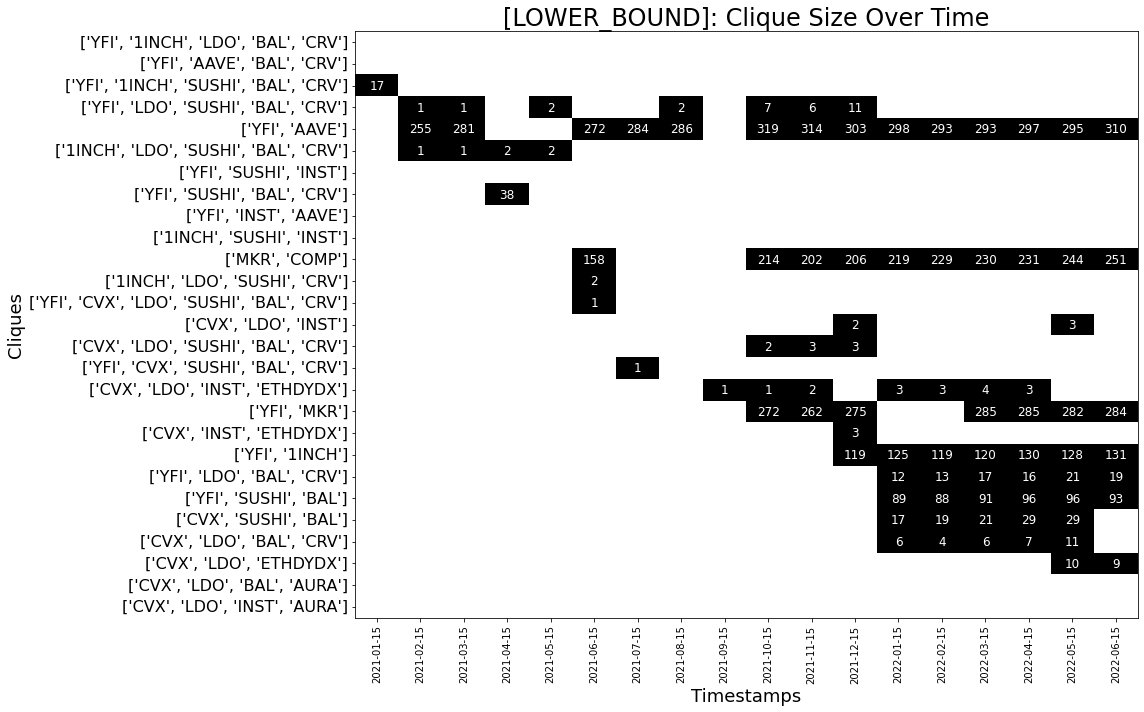

In [58]:
## show lower bound
plot_clique_size_over_time(metric_dataframes,method='lower_bound', group='sample', save=True, show=True)

### Fig: total_influence

In [154]:
FONT_SIZE_TEXT = 12
FONT_SIZE_LABEL = 14
FONT_SIZE_TITLE = 18
FONT_SIZE_VALUE = 10
FIG_SIZE = (18, 15)

/tmp/ipykernel_1985956/1795906789.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])


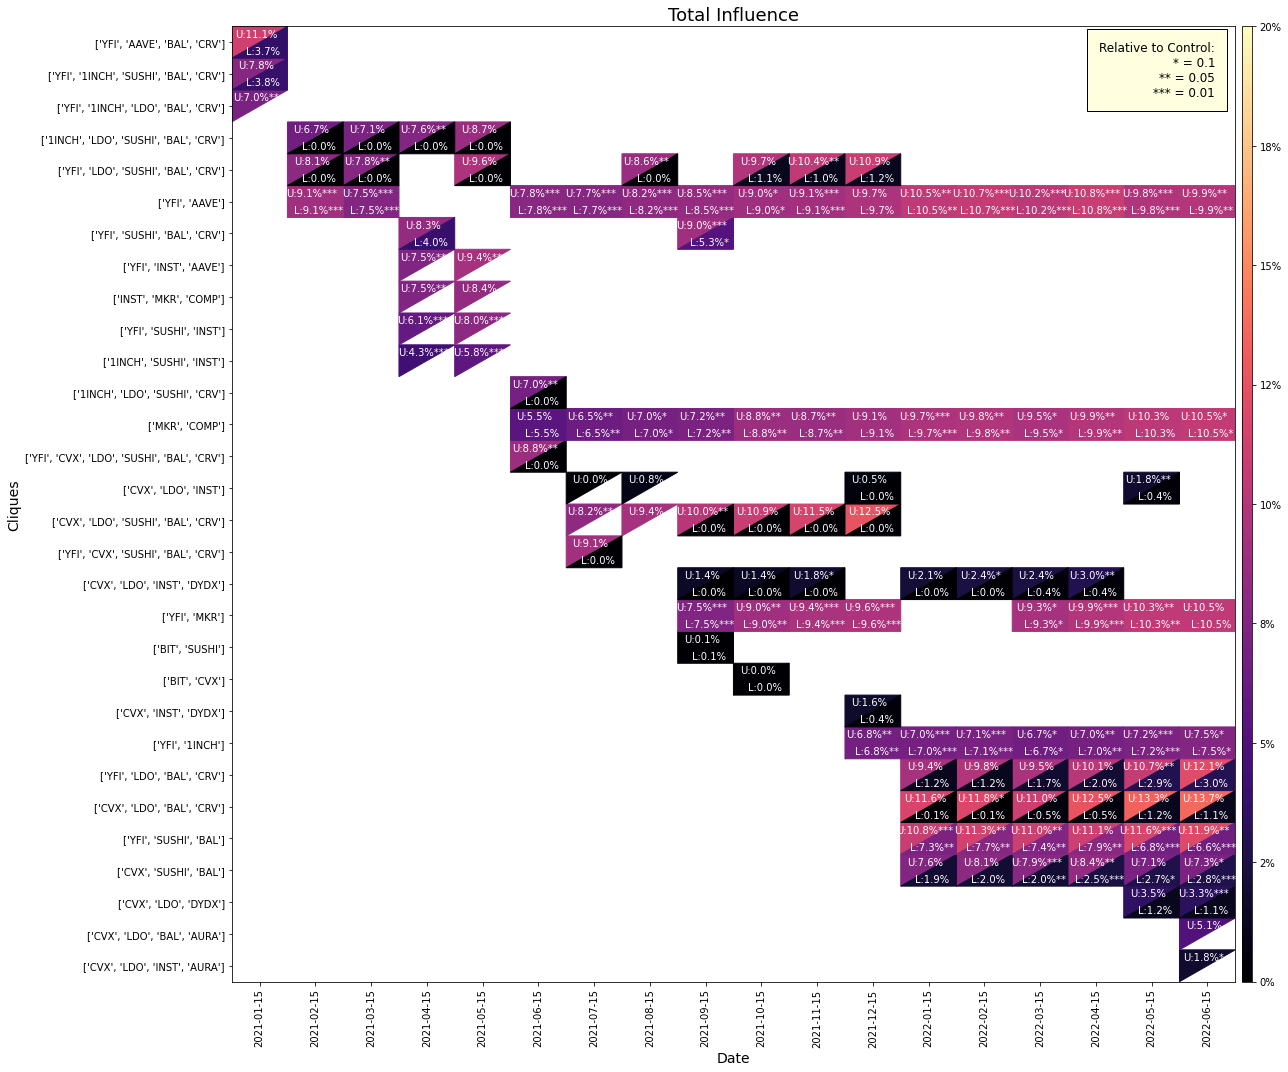

In [170]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_total_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['total_influence'] * 100
    df_l = metric_dataframes['lower_bound']['sample']['total_influence'] * 100

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['total_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['total_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['total_influence'] * 100

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=20)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,1) if not np.isnan(value_u) else ""}%{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,1) if not np.isnan(value_l) else ""}%{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=12))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title('Total Influence', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/total_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_total_influence_percentage(metric_dataframes, save=True, show=True)

### Fig: gini_total_influence

In [23]:
metric_dataframes['upper_bound']['sample']['gini_total_influence'].T.mean().mean()
# metric_dataframes['lower_bound']['sample']['gini_total_influence'].T.mean().median()

0.8796976719895521

/tmp/ipykernel_1985956/1354495013.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val,2)}' for val in tick_vals])


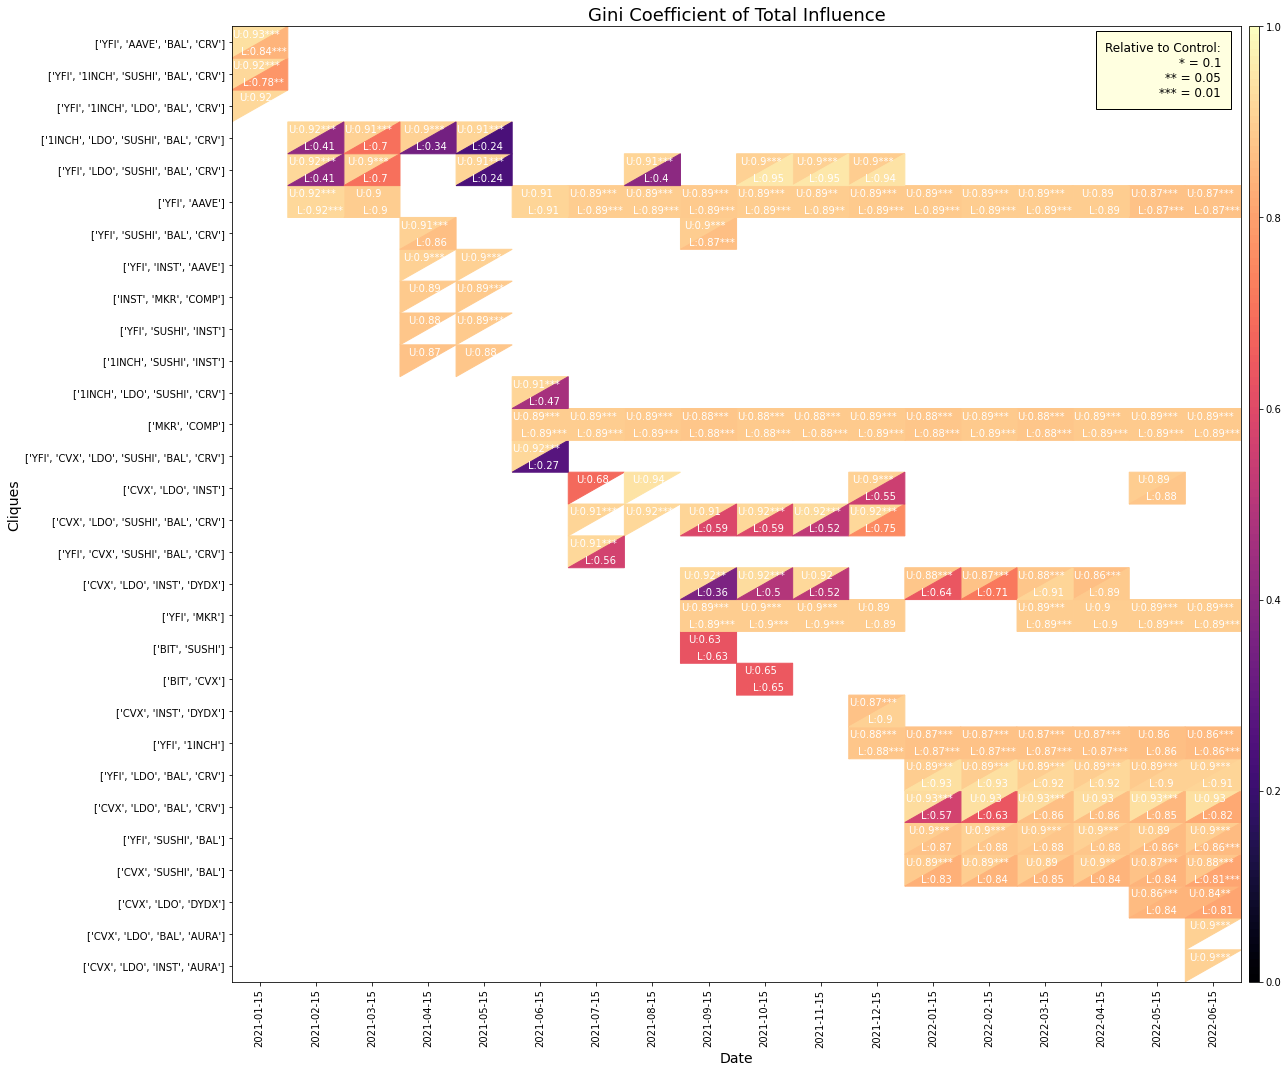

In [162]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

def plot_gini_total_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['gini_total_influence'] 
    df_l = metric_dataframes['lower_bound']['sample']['gini_total_influence'] 

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['gini_total_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['gini_total_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['gini_total_influence'] 

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=1)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,2) if not np.isnan(value_u) else ""}{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,2) if not np.isnan(value_l) else ""}{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val,2)}' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title('Gini Coefficient of Total Influence', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/gini_total_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_gini_total_influence_percentage(metric_dataframes, save=True, show=True)

### Fig: internal_influence 

In [108]:
metric_dataframes['upper_bound']['sample']['internal_influence'].T.max()

0.31625817833491465

/tmp/ipykernel_1985956/4264130651.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])


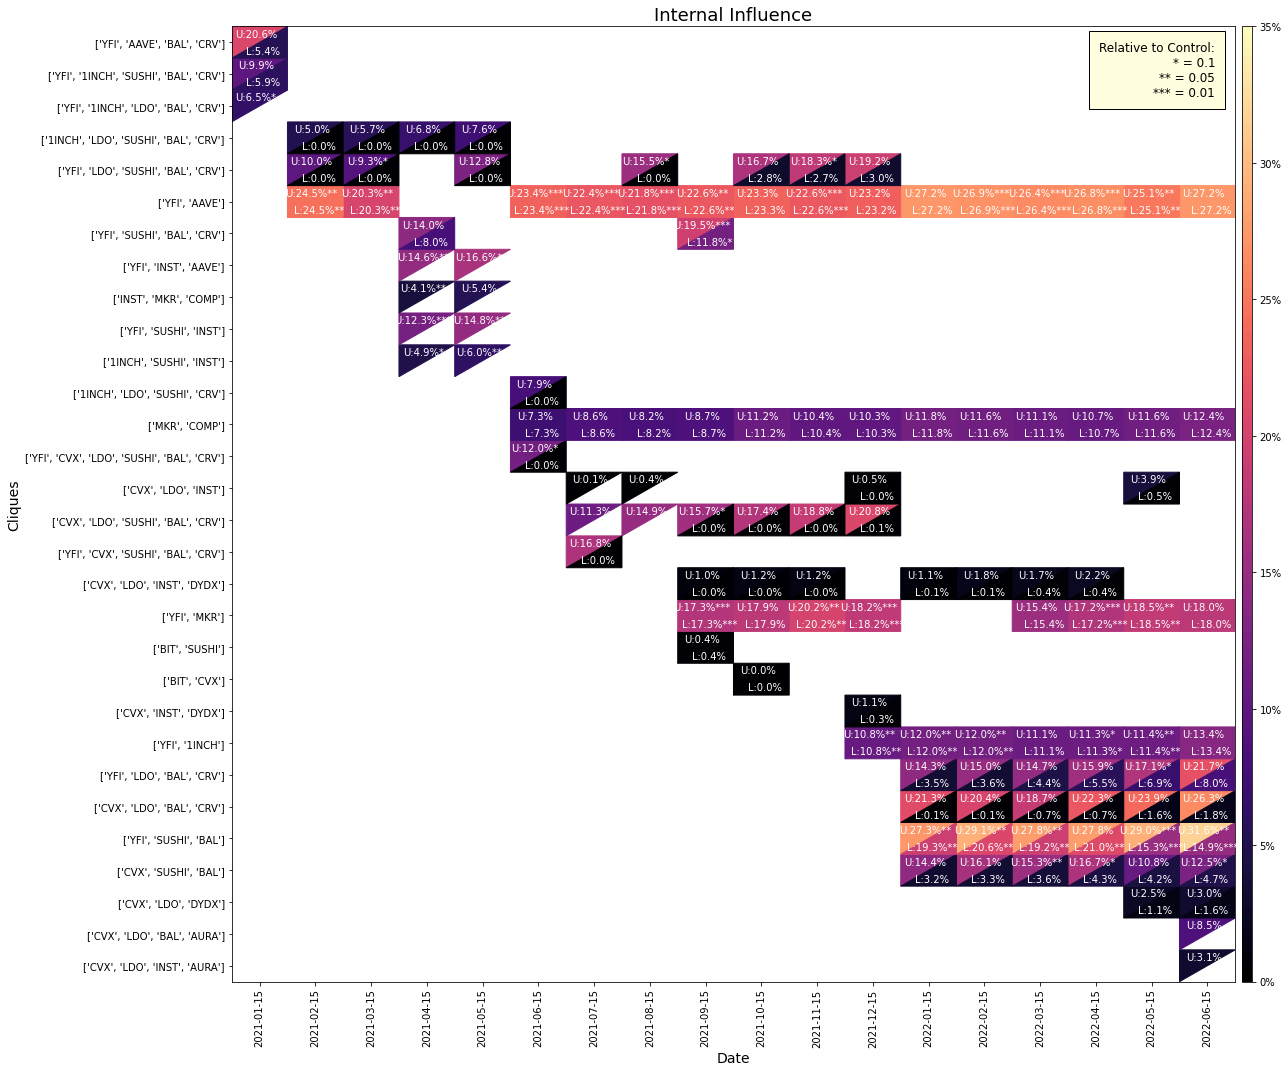

In [169]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches


def plot_internal_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['internal_influence'] * 100
    df_l = metric_dataframes['lower_bound']['sample']['internal_influence'] * 100

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['internal_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['internal_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['internal_influence'] * 100

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=35)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,1) if not np.isnan(value_u) else ""}%{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,1) if not np.isnan(value_l) else ""}%{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title('Internal Influence', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/internal_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_internal_influence_percentage(metric_dataframes, save=True, show=True)

### Fig: gini_internal_influence

/tmp/ipykernel_1985956/751950581.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val,2)}' for val in tick_vals])


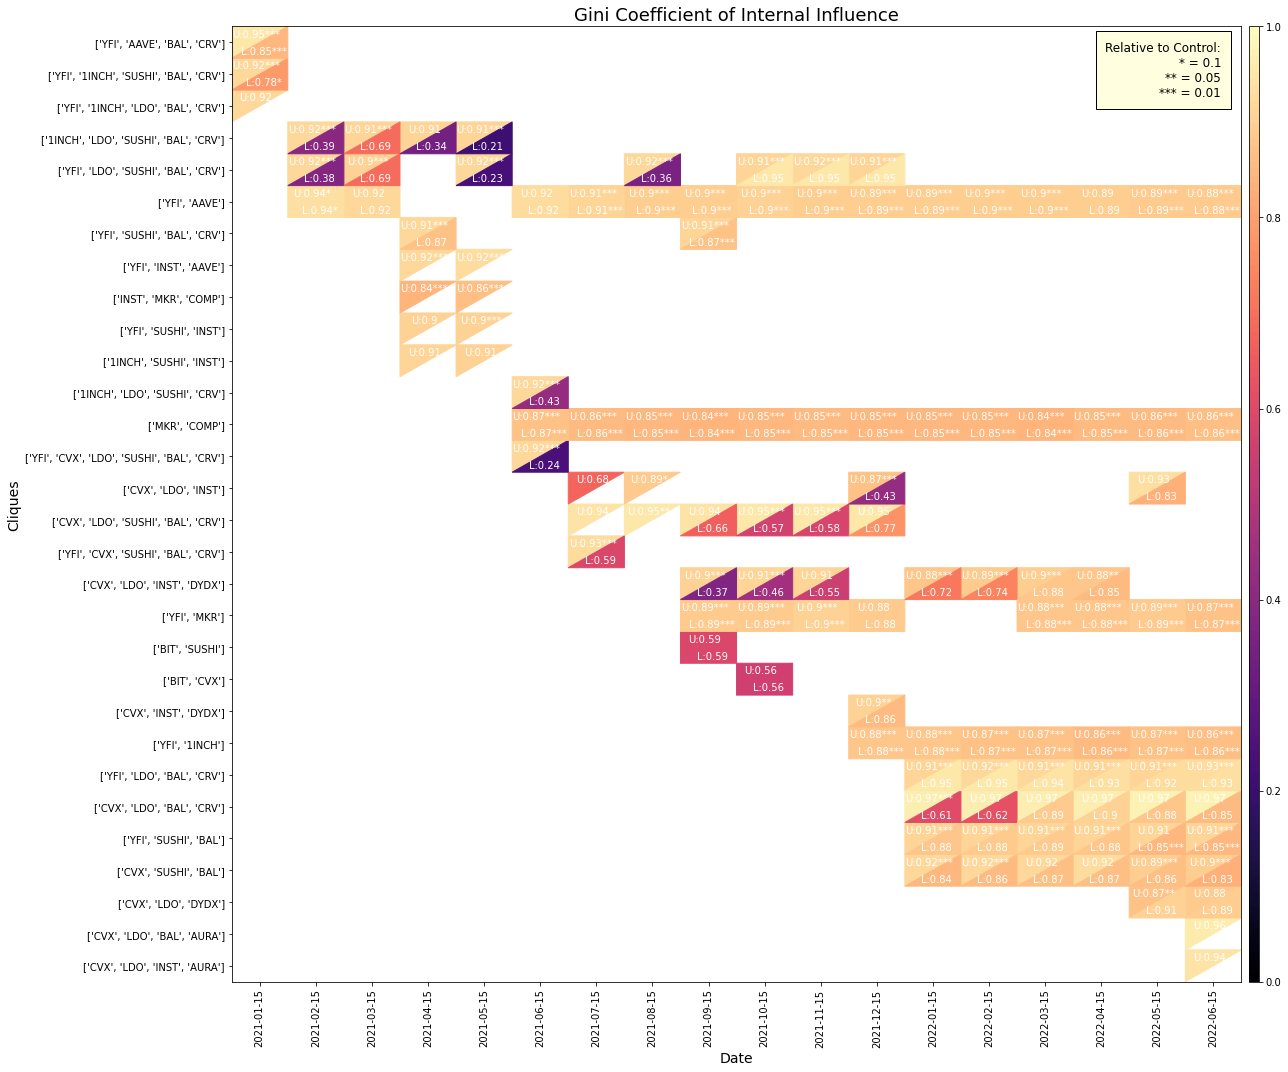

In [164]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

def plot_gini_external_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['gini_internal_influence'] 
    df_l = metric_dataframes['lower_bound']['sample']['gini_internal_influence'] 

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['gini_internal_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['gini_internal_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['gini_internal_influence'] 

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=1)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u, 2) if not np.isnan(value_u) else ""}{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,2) if not np.isnan(value_l) else ""}{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val,2)}' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title('Gini Coefficient of Internal Influence', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/gini_internal_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_gini_external_influence_percentage(metric_dataframes, save=True, show=True)

### Fig: external_influence

/tmp/ipykernel_1985956/265624558.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])


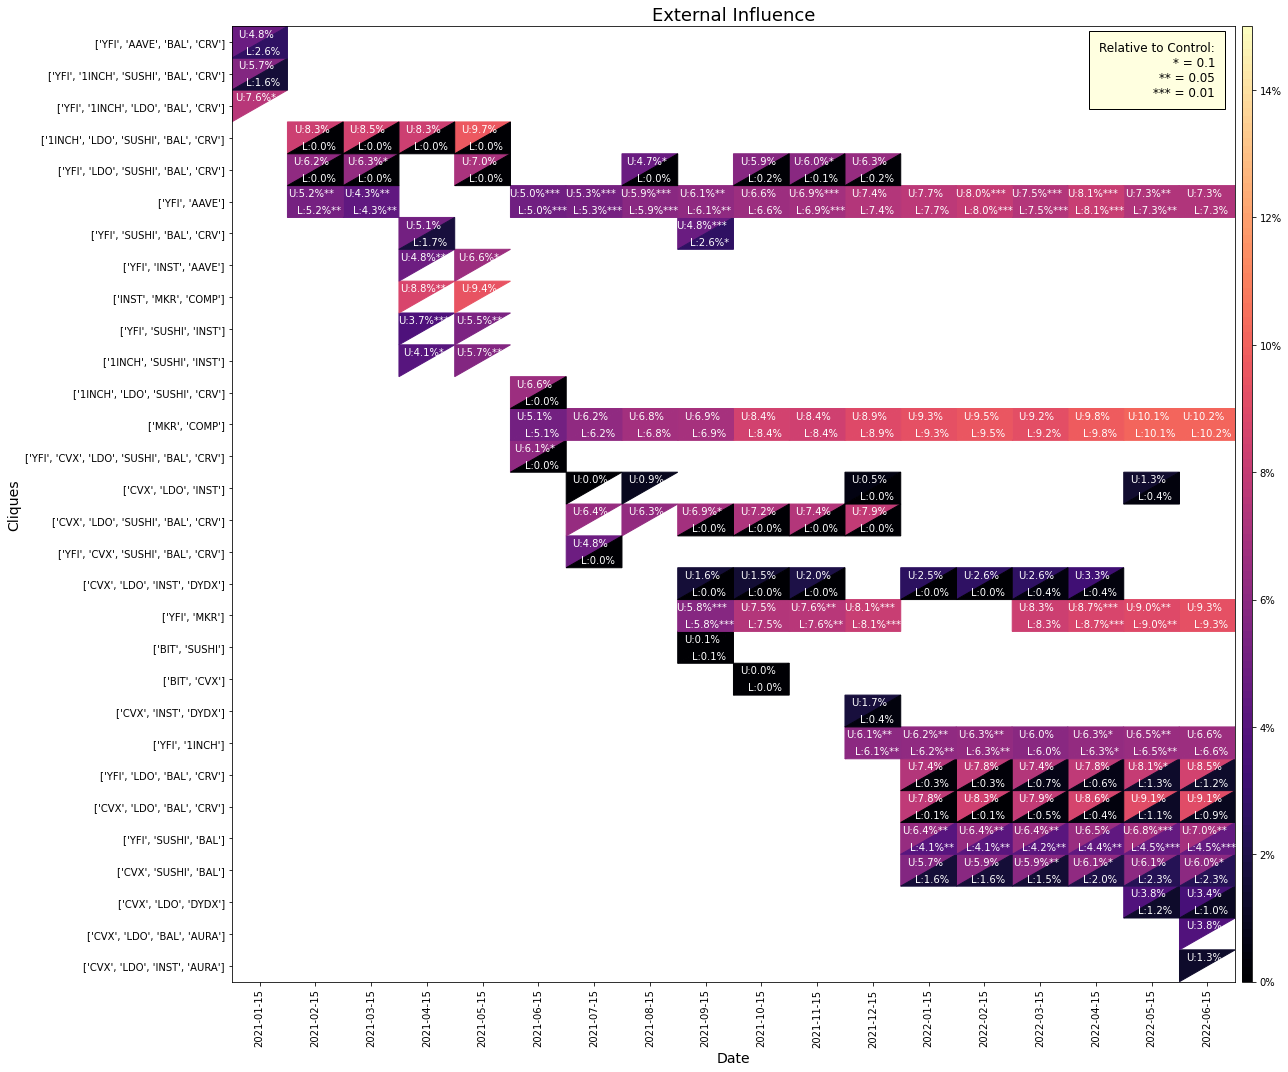

In [168]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

def plot_external_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['external_influence'] * 100
    df_l = metric_dataframes['lower_bound']['sample']['external_influence'] * 100

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['external_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['external_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['external_influence'] * 100

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=15)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,1) if not np.isnan(value_u) else ""}%{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,1) if not np.isnan(value_l) else ""}%{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title('External Influence', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/external_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()
        
        


# Assuming metric_dataframes is already defined somewhere in your code
plot_external_influence_percentage(metric_dataframes, save=True, show=True)

### Fig: gini_external_influence

/tmp/ipykernel_1985956/642222468.py:105: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val,2)}' for val in tick_vals])


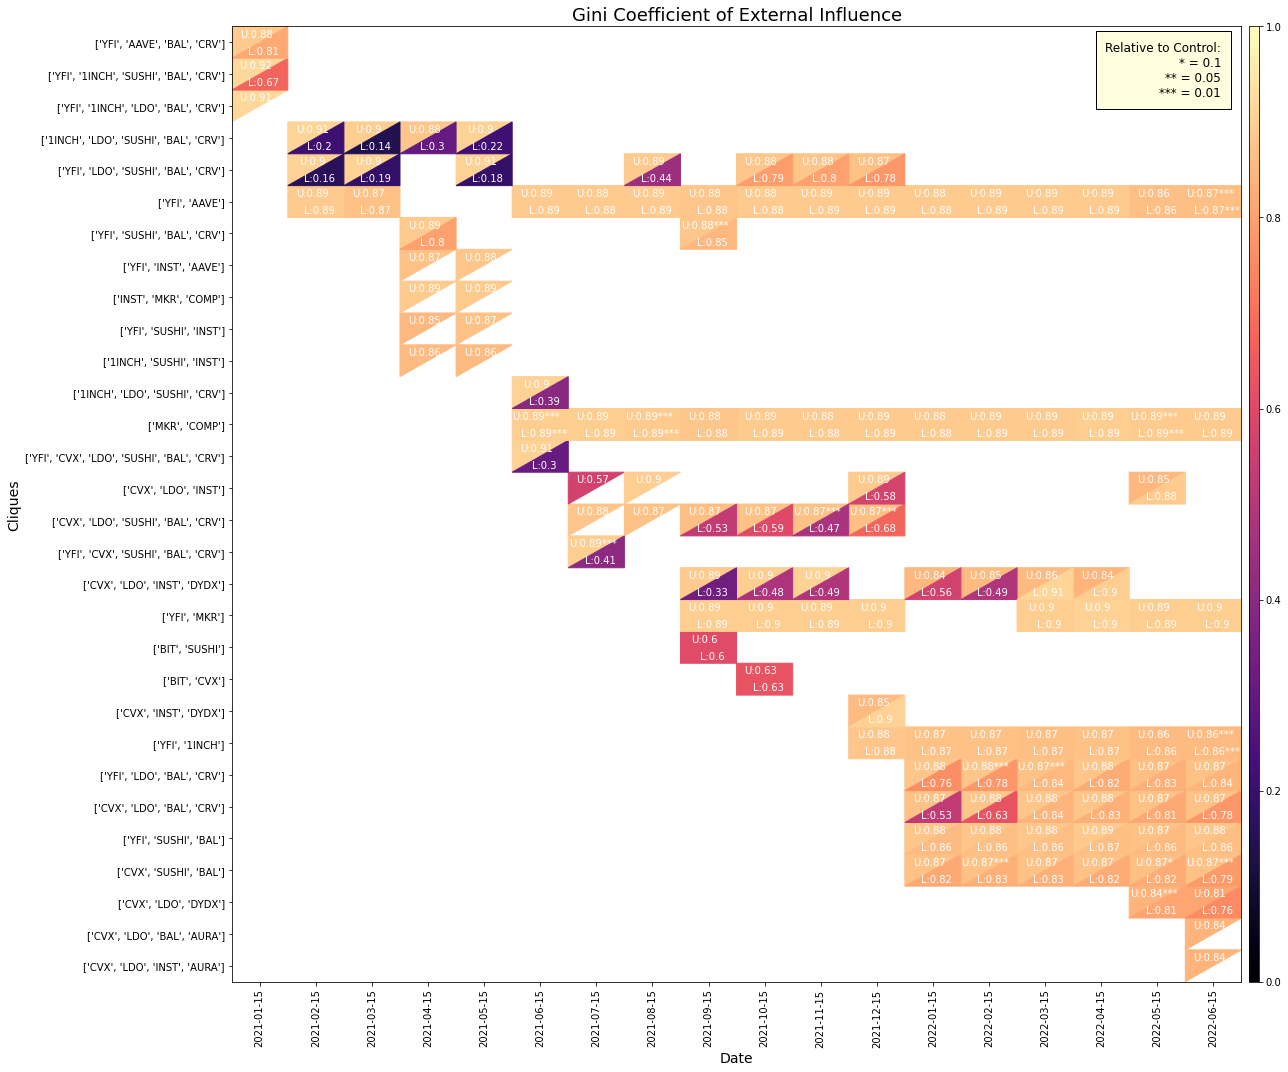

In [171]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

def plot_external_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['gini_external_influence'] 
    df_l = metric_dataframes['lower_bound']['sample']['gini_external_influence'] 

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['gini_external_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['gini_external_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['gini_external_influence'] 

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=1)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,2) if not np.isnan(value_u) else ""}{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,2) if not np.isnan(value_l) else ""}{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val,2)}' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title('Gini Coefficient of External Influence', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/gini_external_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_external_influence_percentage(metric_dataframes, save=True, show=True)

### Fig: wealth_clique

/tmp/ipykernel_1985956/3130312607.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val)}' for val in tick_vals])


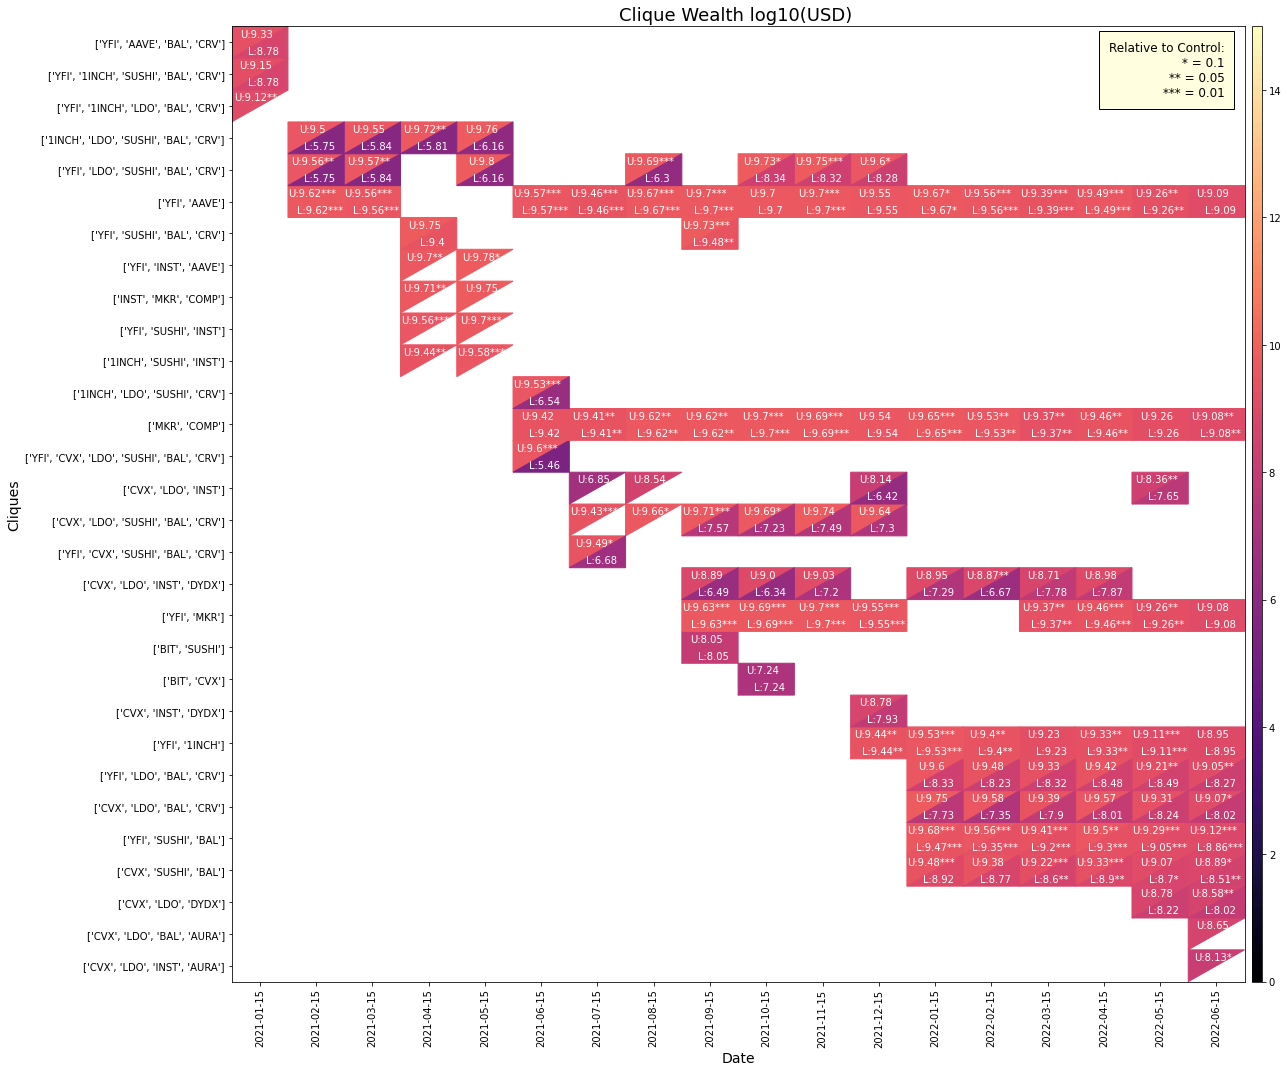

In [172]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches


def plot_external_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = np.log10(metric_dataframes['upper_bound']['sample']['wealth_clique'])
    df_l = np.log10(metric_dataframes['lower_bound']['sample']['wealth_clique'])

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['wealth_clique']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['wealth_clique']
    
    # reindex
    df_index = np.log10(metric_dataframes['upper_bound']['sample']['wealth_clique'])

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=15)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,2) if not np.isnan(value_u) else ""}{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,2) if not np.isnan(value_l) else ""}{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val)}' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title('Clique Wealth log10(USD) ', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/clique_wealth.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_external_influence_percentage(metric_dataframes, save=True, show=True)

### Fig: gini_wealth_clique

/tmp/ipykernel_1985956/1855302499.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val,2)}' for val in tick_vals])


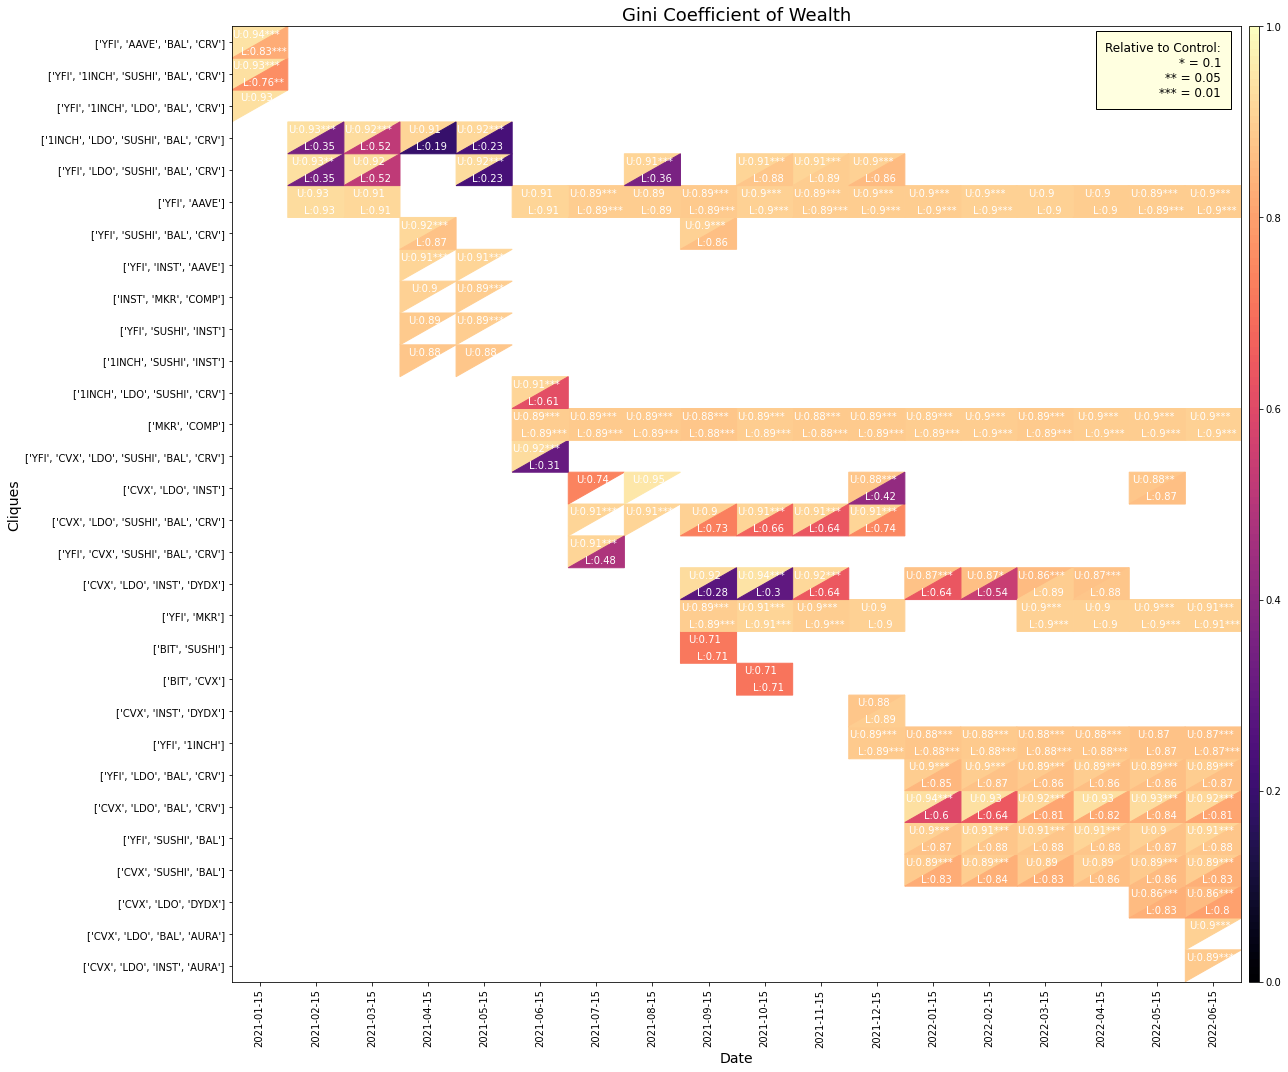

In [173]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches


def plot_external_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['gini_wealth_clique'] 
    df_l = metric_dataframes['lower_bound']['sample']['gini_wealth_clique'] 

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['gini_wealth_clique']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['gini_wealth_clique']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['gini_wealth_clique'] 

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=1)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,2) if not np.isnan(value_u) else ""}{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,2) if not np.isnan(value_l) else ""}{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val,2)}' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title('Gini Coefficient of Wealth', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/gini_clique_wealth.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_external_influence_percentage(metric_dataframes, save=True, show=True)

### Fig: median_wealth_level_clique || Note: This is the median position size in a clique

In [138]:
np.log10(metric_dataframes['lower_bound']['sample']['median_wealth_level_clique']).T.mean().describe()

count    21.000000
mean      6.288291
std       0.450455
min       5.459864
25%       6.004904
50%       6.274708
75%       6.585403
max       7.227899
dtype: float64

In [146]:
round(10 ** 6.288291,2)

1942186.81

/tmp/ipykernel_1985956/1459864636.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val)}' for val in tick_vals])


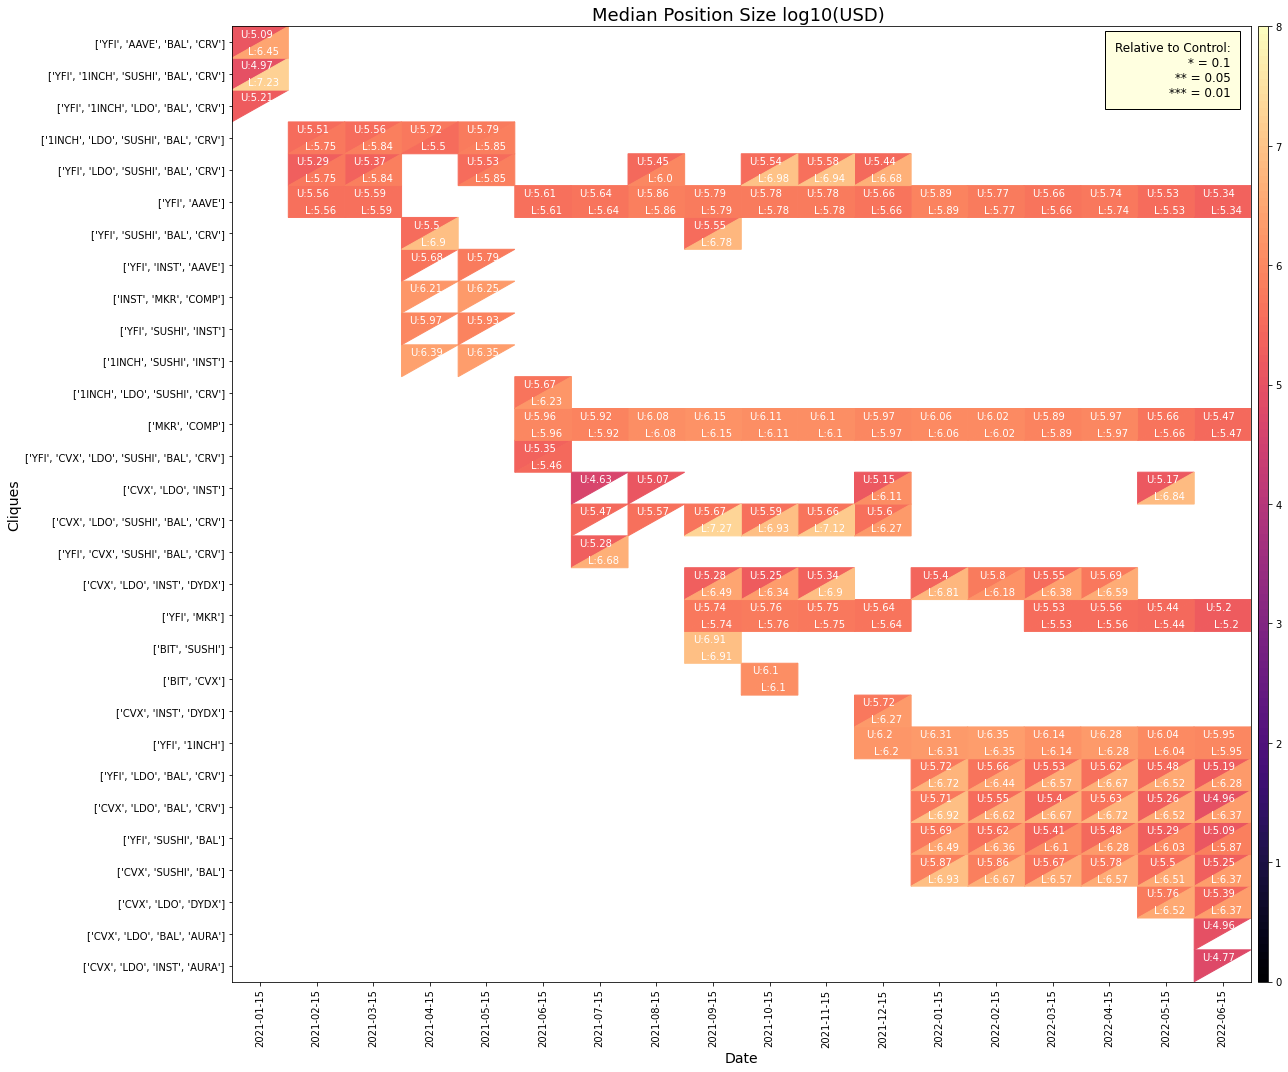

In [175]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

def plot_median_wealth_cliques(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = np.log10(metric_dataframes['upper_bound']['sample']['median_wealth_level_clique'])
    df_l = np.log10(metric_dataframes['lower_bound']['sample']['median_wealth_level_clique'])

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['median_wealth_level_clique']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['median_wealth_level_clique']
    
    # reindex
    df_index = np.log10(metric_dataframes['upper_bound']['sample']['median_wealth_level_clique'])

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=8)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,2) if not np.isnan(value_u) else ""}{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,2) if not np.isnan(value_l) else ""}{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val)}' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title('Median Position Size log10(USD) ', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/median_clique_wealth.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_median_wealth_cliques(metric_dataframes, save=True, show=True)

### Fig: median_no_assets_clique


In [151]:
metric_dataframes['lower_bound']['sample']['median_no_assets_clique'].T.mean().describe()

count    21.000000
mean      9.336656
std       2.528643
min       4.600000
25%       7.857143
50%       9.000000
75%      12.000000
max      12.928571
dtype: float64

/tmp/ipykernel_1985956/151315395.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val)}' for val in tick_vals])


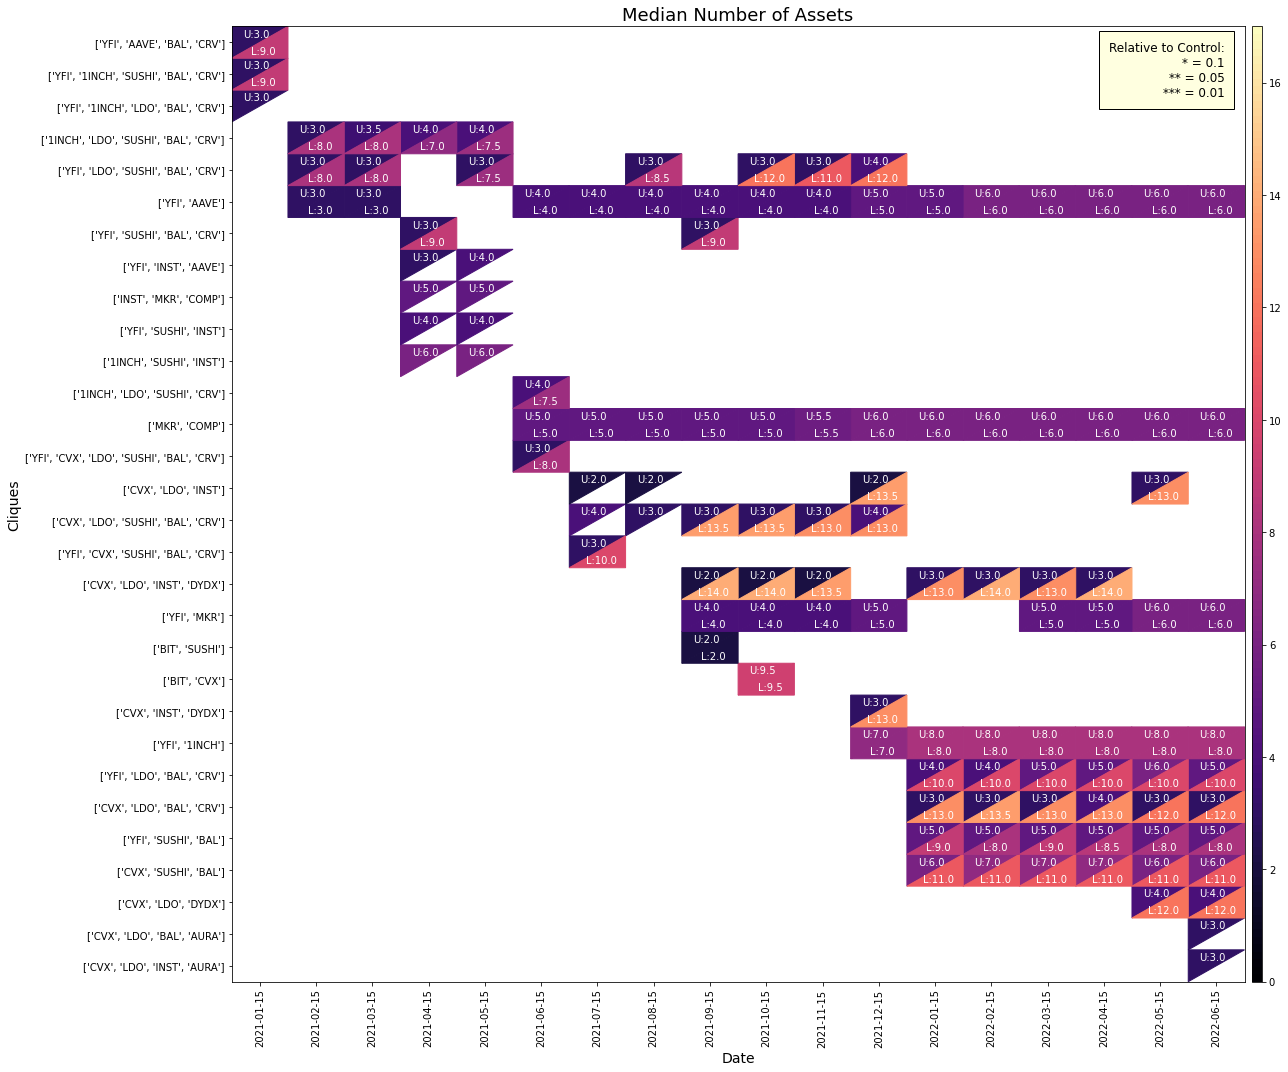

In [176]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

def plot_median_no_assets_clique(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['median_no_assets_clique']
    df_l = metric_dataframes['lower_bound']['sample']['median_no_assets_clique']

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['median_no_assets_clique']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['median_no_assets_clique']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['median_no_assets_clique']

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=17)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,1) if not np.isnan(value_u) else ""}{pval_u}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,1) if not np.isnan(value_l) else ""}{pval_l}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val)}' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Cliques', size=FONT_SIZE_LABEL)
    ax.set_title('Median Number of Assets', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/median_number_assets_clique.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_median_no_assets_clique(metric_dataframes, save=True, show=True)

### Fig: max_influence_label

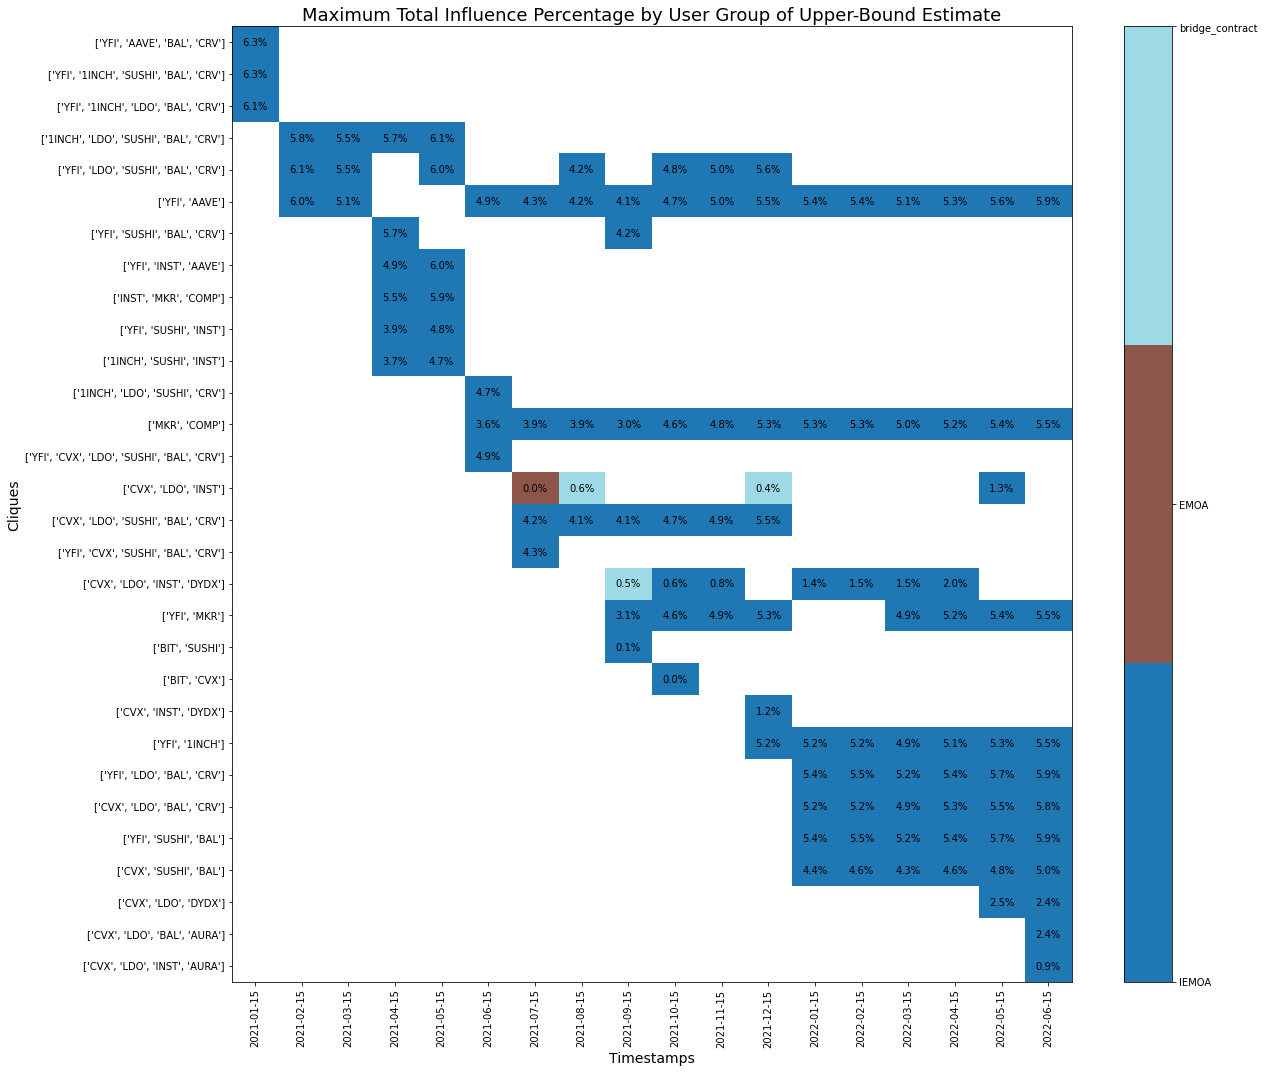

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

FONT_SIZE_TEXT = 12
FONT_SIZE_LABEL = 14
FONT_SIZE_TITLE = 18
FONT_SIZE_VALUE = 10
FIG_SIZE = (18, 15)

def plot_max_influence_label(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    # Define df
    df = metric_dataframes[method][group]['max_influence_label']
    df_pv = metric_dataframes[method]['pvalues']['max_influence_label']
    
    # Common index calculation
    df_index = metric_dataframes[method]['sample']['size_clique']
    first_occurrence_indices = (df_index.T > 0).idxmax()
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
    cliques_order = min_indices.sort_values().index.tolist()
    
    df = df.reindex(cliques_order)
    df_pv = df_pv.reindex(cliques_order)
    # Flatten multi-level columns (if they exist)
    # df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]

    # Extract the labels into separate DataFrames
    df_labels_raw = df.applymap(lambda x: x[0] if isinstance(x, tuple) else np.nan)
    df_labels = df_labels_raw.replace(token_lookup)  # Ensure token_lookup is defined and correct

    # Extract values into separate DataFrames
    df_values = df.applymap(lambda x: x[1] if isinstance(x, tuple) else np.nan)

    # Get unique labels
    unique_labels = df_labels.stack().unique()

    # Create a colormap with a unique color for each label
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    colormap = mcolors.ListedColormap(colors)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Plot colored cells based on labels
    cax = ax.imshow(df_labels.replace(dict(zip(unique_labels, range(len(unique_labels))))), cmap=colormap,
                    aspect='auto', interpolation='none')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df_labels.columns)))
    ax.set_yticks(np.arange(len(df_labels.index)))
    ax.set_xticklabels(df_labels.columns, rotation='vertical')
    ax.set_yticklabels(df_labels.index, fontsize=FONT_SIZE_VALUE, va='center', linespacing=1.5)

    # Annotate the chart with metric values, using the values from df_values
    for i in range(len(df_labels.index)):
        for j in range(len(df_labels.columns)):
            label = df_labels.iloc[i, j]  # Use .iloc for direct indexing
            value = df_values.iloc[i, j]  # Use .iloc for direct indexing
            pval = df_pv.values[i, j]
            pval = pval_to_significance(pval)
            if pd.notna(value):  # Check for non-NaN values
                text = ax.text(j, i, f'{value*100:.1f}{pval}%', ha='center', va='center', color='black', fontsize=FONT_SIZE_VALUE)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=FONT_SIZE_LABEL)
    plt.ylabel('Cliques', fontsize=FONT_SIZE_LABEL)
    fmethod = method.replace('_','-').title()
    plt.title(f'Maximum Total Influence Percentage by User Group of {fmethod} Estimate', fontsize=FONT_SIZE_TITLE)

    # Create a color bar indicating labels
    cbar = fig.colorbar(cax, ticks=range(len(unique_labels)))
    cbar.ax.set_yticklabels(unique_labels)
    
    # Add the custom box with significance information
    # plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))

    # Adjust spacing for vertical axis labels
    plt.tight_layout()

    # Save the plot to the specified output path
    if save:
        plt.savefig(join(output_path, f'max_influence_label_{method}.png'))

    # Display the plot or close it based on the show parameter
    if show != True:
        plt.close(fig)
    else:
        plt.show()

# Example usage:
plot_max_influence_label(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True)

In [191]:
'upper_bound'

'Upper-Bound'

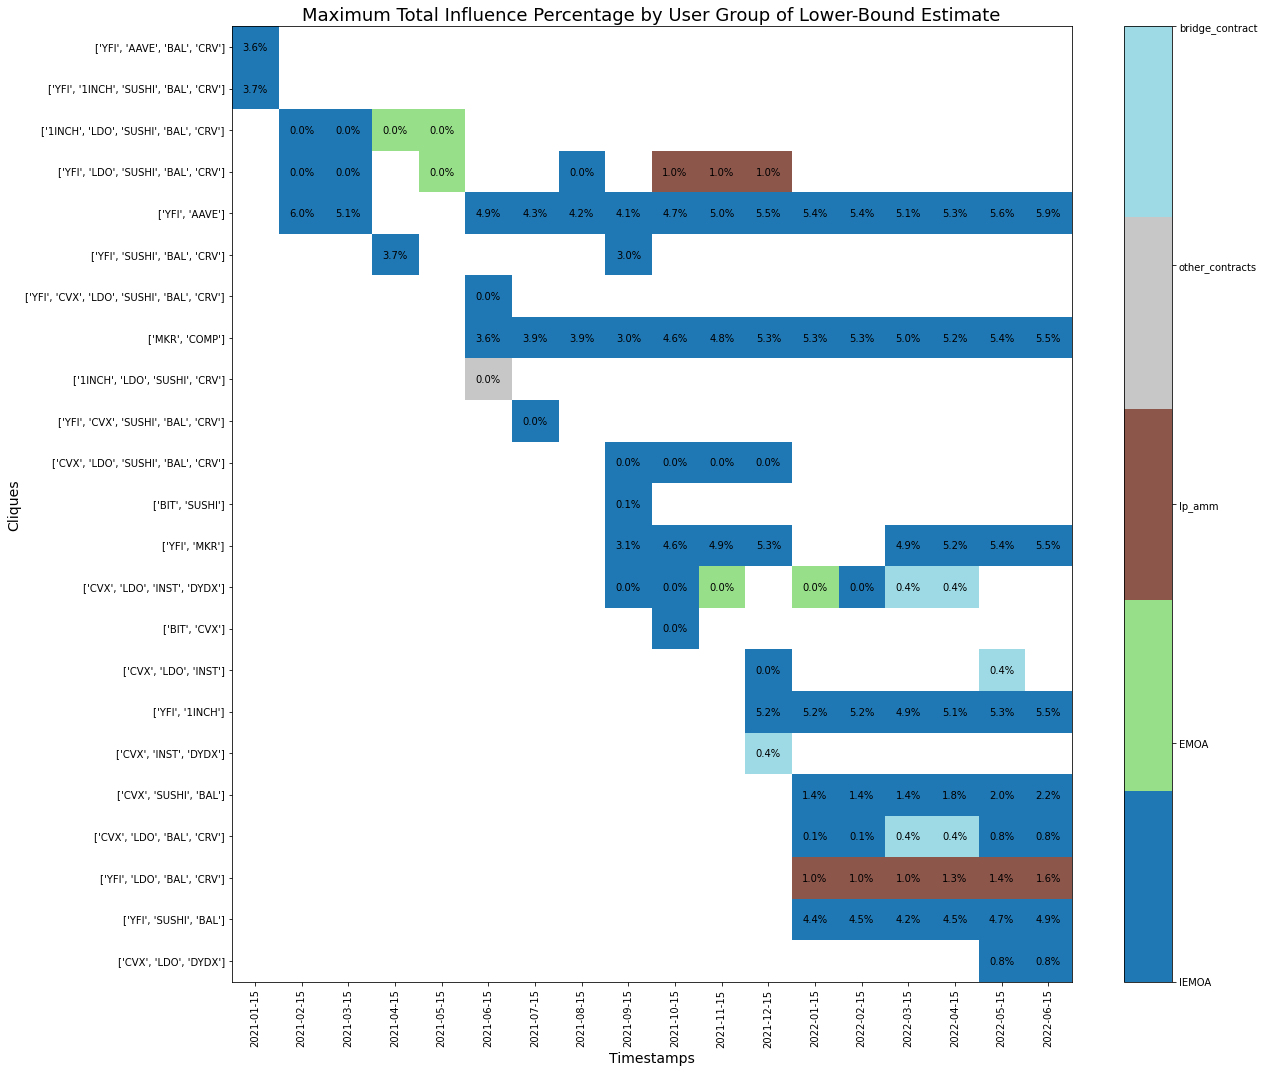

In [198]:
plot_max_influence_label(metric_dataframes, method='lower_bound', group='sample', output_path="output/cliques/", save=True, show=True)
# plot_max_influence_label(metric_dataframes, method='upper_bound', group='control', output_path="output/cliques/", save=True, show=True)

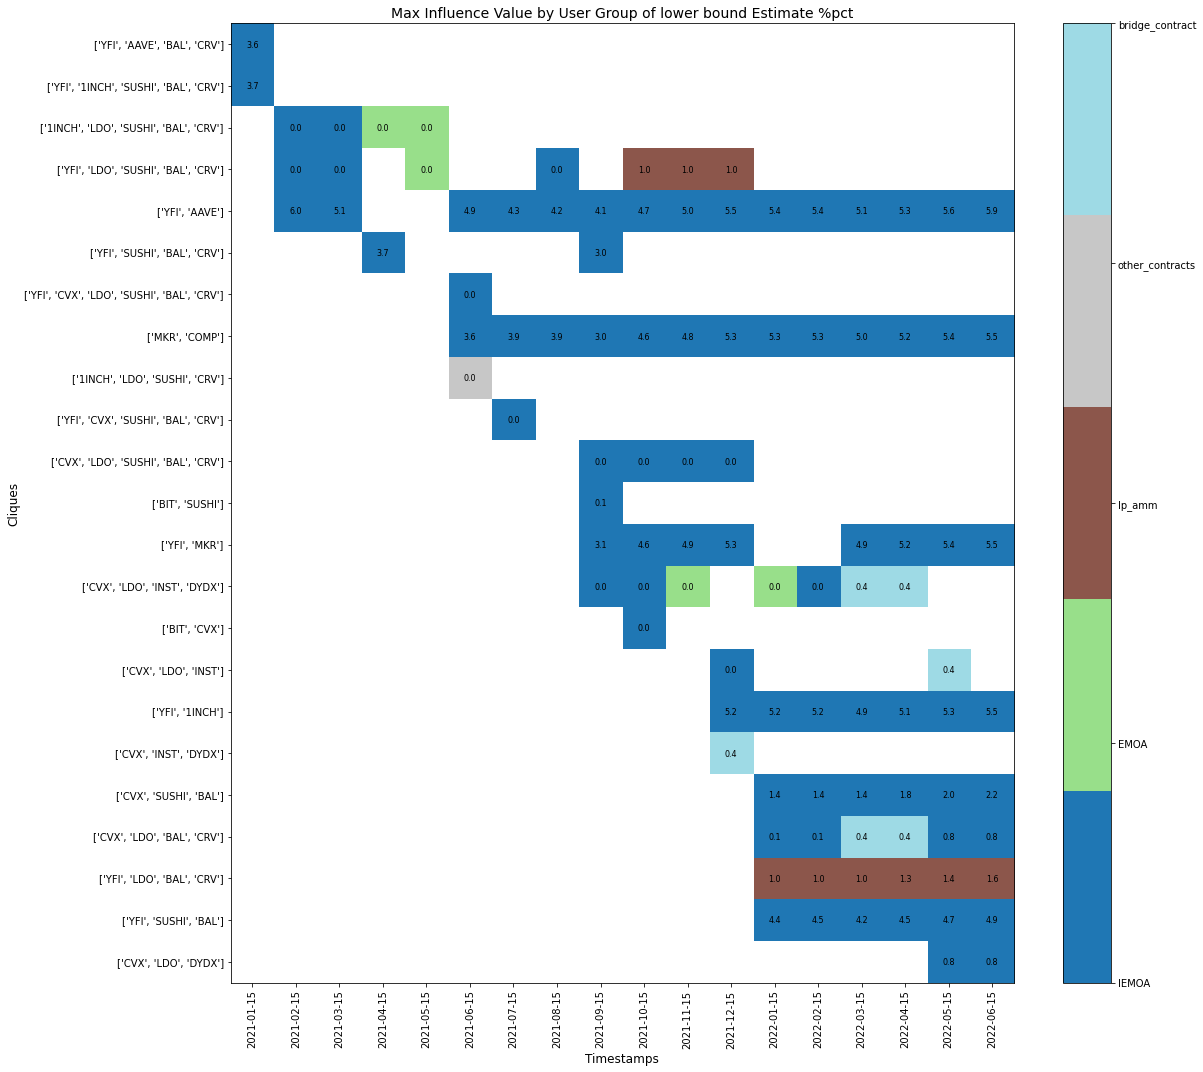

In [96]:
plot_max_influence_label(metric_dataframes, method='lower_bound', group='sample', output_path="output/cliques/", save=True, show=True)
# plot_max_influence_label(metric_dataframes, method='lower_bound', group='control', output_path="output/cliques/", save=True, show=True)